In [1]:
import sqlite3
import pandas as pd

## Step 1: Create SQLite Database

### ERD

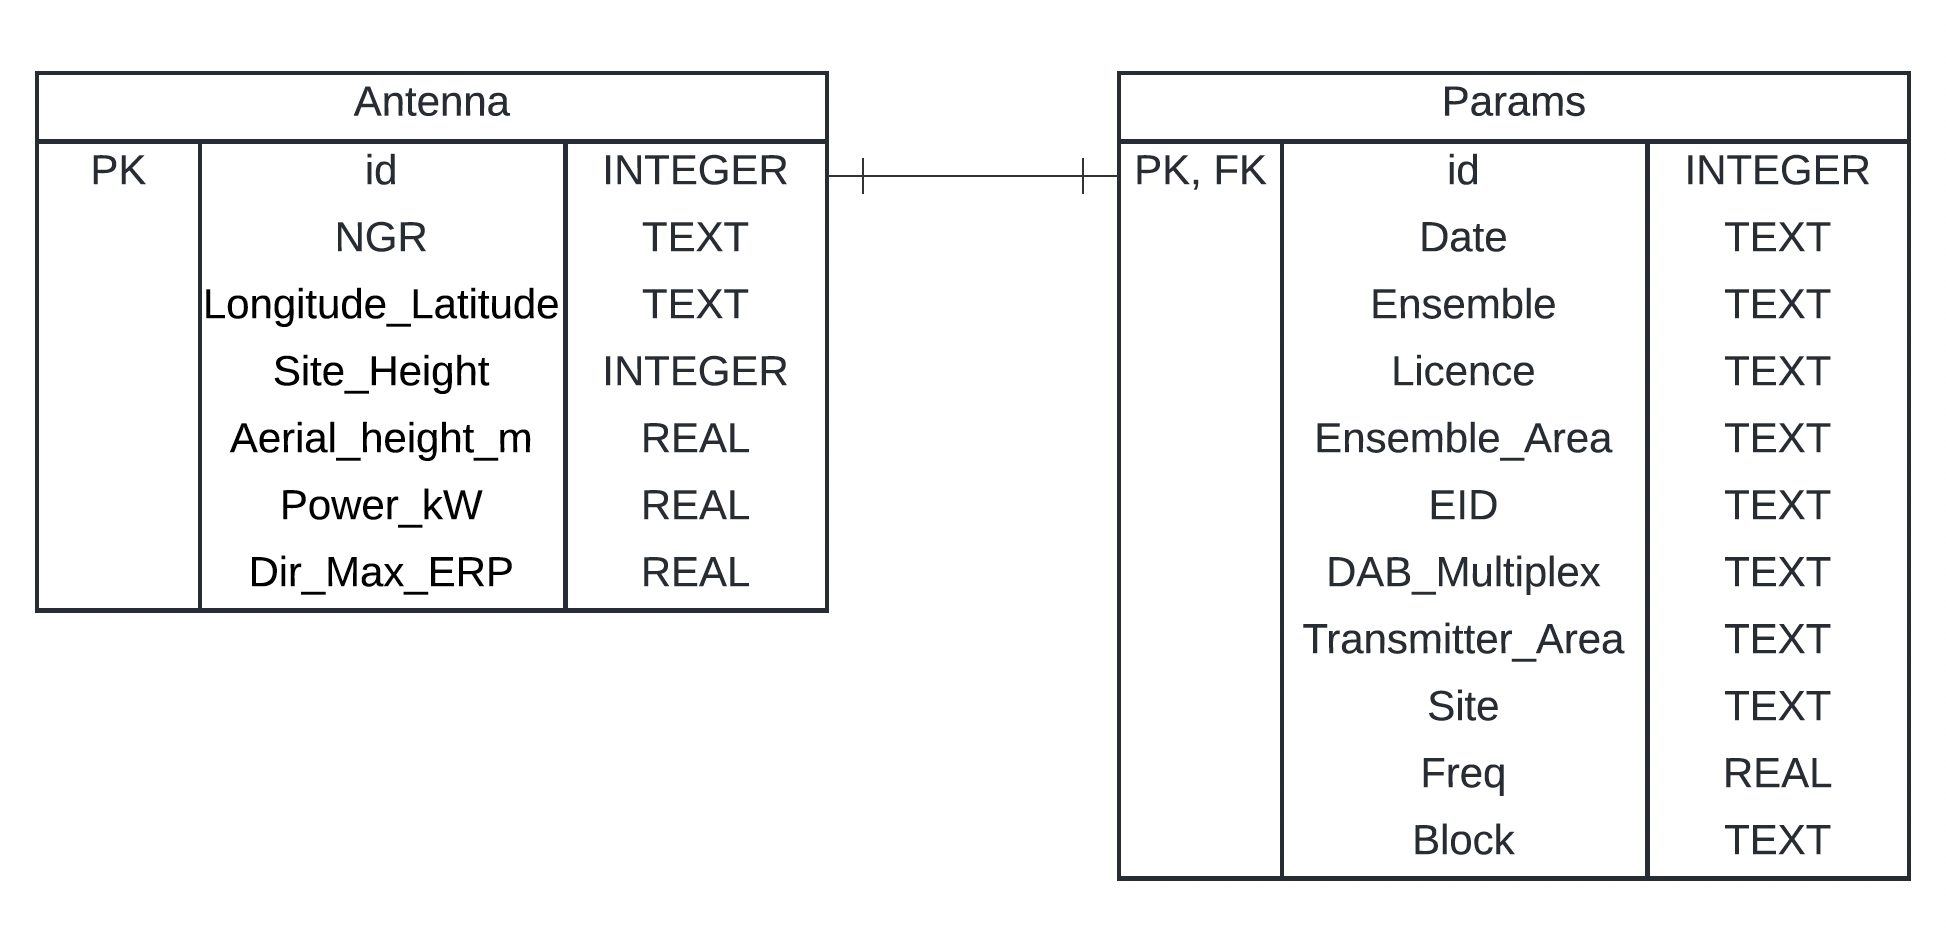

In [2]:
# Step 1: Create SQLite Database and Tables
def create_database():
    """
    Creates an SQLite database and initializes two tables:
    1. TxAntennaDAB: Stores information about the antenna sites, including location, height, and power.
    2. TxParamsDAB: Stores parameters of DAB transmissions, such as date, ensemble area, and frequency.
    """
    conn = sqlite3.connect('formative_week2.db')  # Connect to SQLite database
    cursor = conn.cursor()
    
    # Create TxAntennaDAB table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS TxAntennaDAB (
            id INTEGER PRIMARY KEY,               -- Unique identifier for each antenna
            NGR TEXT,                             -- National Grid Reference
            Longitude_Latitude TEXT,              -- Longitude and Latitude as a single string
            Site_Height INTEGER,                  -- Height of the antenna site in meters
            Aerial_height_m REAL,                 -- Height of the antenna in meters
            Power_kW REAL,                        -- Effective Radiated Power (ERP) in kilowatts
            Dir_Max_ERP REAL                      -- Directional Max ERP
        )
    ''')
    
    # Create TxParamsDAB table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS TxParamsDAB (
            id INTEGER PRIMARY KEY,               -- Unique identifier for each record
            Date TEXT,                            -- Date of transmission
            Ensemble TEXT,                        -- Ensemble group
            Licence TEXT,                         -- Licence ID
            Ensemble_Area TEXT,                   -- Broadcast area name
            EID TEXT,                             -- Multiplex Block ID (e.g., C19A)
            DAB_Multiplex TEXT,                   -- Extracted multiplex type (C18A, C18F, C188)
            Transmitter_Area TEXT,                -- Transmitter Area
            Site TEXT,                            -- Site name
            Freq REAL,                            -- Frequency in MHz
            Block TEXT,                           -- Frequency Block
            FOREIGN KEY (id) REFERENCES TxAntennaDAB (id) -- Links to TxAntennaDAB by ID
        )
    ''')
    
    conn.commit() # Save changes
    conn.close() # Close connection
    print("\nStep1: Database and tables created successfully.")

## Step 2: Load CSV Files and Clean Data

In [3]:
def load_and_clean_data(antenna_csv, params_csv):
    """
    Loads the given CSV files, cleans the data, and standardises column names:
    - Antenna data: Includes site information, power, and antenna height.
    - Parameters data: Includes multiplex details, frequency, and site.
    Returns cleaned pandas DataFrames for both datasets.
    """
    # Load Antenna data
    df_antenna = pd.read_csv(antenna_csv, encoding='ISO-8859-1')
    df_antenna = df_antenna.rename(columns={
        'Site Height': 'Site_Height',      # Standardises the column name
        'In-Use Ae Ht': 'Aerial_height_m', # Rename with unit
        'In-Use ERP Total': 'Power_kW',    # Rename with unit
        'Dir Max ERP': 'Dir_Max_ERP'       # Standardises the column name
    })
    # Keep only the relevant columns
    df_antenna = df_antenna[['id', 'NGR', 'Longitude/Latitude', 'Site_Height', 'Aerial_height_m', 'Power_kW', 'Dir_Max_ERP']]
    
    # Load Parameters data
    df_params = pd.read_csv(params_csv, encoding='ISO-8859-1')
    df_params = df_params.rename(columns={
        'Ensemble Area': 'Ensemble_Area',         # Standardises the column name
        'Transmitter Area': 'Transmitter_Area',   # Standardises the column name
        'Freq.': 'Freq'                           # Standardises the column name
    })
    # Keep only the relevant columns
    df_params = df_params[['id', 'Date', 'Ensemble', 'Licence', 'Ensemble_Area', 'EID', 'Transmitter_Area', 'Site', 'Freq', 'Block']]
    
    return df_antenna, df_params

##  Step 3: Save Data to Database

In [4]:
def save_data_to_database(df_antenna, df_params):
    """
    Saves the cleaned DataFrames to the SQLite database as tables:
    - TxAntennaDAB: Antenna data.
    - TxParamsDAB: Parameters data.
    """
    conn = sqlite3.connect('formative_week2.db')
    
    # Save DataFrames to database
    df_antenna.to_sql('TxAntennaDAB', conn, if_exists='replace', index=False)
    df_params.to_sql('TxParamsDAB', conn, if_exists='replace', index=False)
    
    conn.close()
    print("\nStep3: Data saved to SQLite database successfully.")

## Step 4: Filter and Add Multiplex Data

In [5]:
def filter_and_add_multiplex():
    """
    Filters out rows with specific NGR values from TxAntennaDAB and adds a DAB_Multiplex column
    to TxParamsDAB to indicate the multiplex type (C18A, C18F, C188).
    """
    conn = sqlite3.connect('formative_week2.db')
    cursor = conn.cursor()

    # Remove unwanted NGR values
    exclude_ngrs = ['NZ02553847', 'SE213515', 'NT05399374', 'NT252675908']
    cursor.execute('''
        DELETE FROM TxAntennaDAB WHERE NGR IN (?, ?, ?, ?)
    ''', exclude_ngrs)
    conn.commit()
    print("\nStep4-1: Unwanted NGR values removed from TxAntennaDAB table.")

    # Add Multiplex column to TxParamsDAB
    multiplexes = ['C18A', 'C18F', 'C188']
    df_params = pd.read_sql('SELECT * FROM TxParamsDAB', conn)
    df_params['DAB_Multiplex'] = df_params['EID'].str.extract('(C18A|C18F|C188)', expand=False) # Create a new column for DAB Multiplex based on EID

    # Save updated data back to the database
    df_params.to_sql('TxParamsDAB', conn, if_exists='replace', index=False)
    conn.close()
    print("\nStep4-2: DAB_Multiplex column added and saved to TxParamsDAB table.")


## Step 5: Execution Workflow

In [6]:
antenna_csv_path = "Data sets/TxAntennaDAB.csv"
params_csv_path = "Data sets/TxParamsDAB.csv"

# Execute the full workflow
create_database()                                                               
df_antenna, df_params = load_and_clean_data(antenna_csv_path, params_csv_path) 
save_data_to_database(df_antenna, df_params)                                   
filter_and_add_multiplex()                                           


Step1: Database and tables created successfully.

Step3: Data saved to SQLite database successfully.

Step4-1: Unwanted NGR values removed from TxAntennaDAB table.

Step4-2: DAB_Multiplex column added and saved to TxParamsDAB table.


## Step 6: Validation

###  Step 6-1: Data Integrity Check

In [11]:
def check_data_integrity():
    """
    Validates the integrity of the data in the database:
    - Checks row counts for both tables.
    - Ensures NGR filtering was successful.
    """
    conn = sqlite3.connect('formative_week2.db')
    cursor = conn.cursor()
    
    # Check row counts
    cursor.execute('SELECT COUNT(*) FROM TxAntennaDAB')
    print(f"Step6-1-1. TxAntennaDAB row count: {cursor.fetchone()[0]}")
    cursor.execute('SELECT COUNT(*) FROM TxParamsDAB')
    print(f"Step6-1-2. TxParamsDAB row count: {cursor.fetchone()[0]}")
    
    # Check if NGR filtering was successful
    exclude_ngrs = ['NZ02553847', 'SE213515', 'NT05399374', 'NT252675908']
    cursor.execute(f'''
        SELECT * FROM TxAntennaDAB 
        WHERE NGR IN ({','.join(['?']*len(exclude_ngrs))})
    ''', exclude_ngrs)
    if cursor.fetchall():
        print("\nStep6-1-3. NGR filtering failed.")
    else:
        print("\nStep6-1-3. NGR filtering successful.")
    # Close the connection
    conn.close()

### Step 6-2: Data Join Check

In [12]:
#  Data Join Check
def check_data_join():
    """
    Ensures that the join between TxAntennaDAB and TxParamsDAB on `id` works correctly.
    """

    conn = sqlite3.connect('formative_week2.db')
    query = '''
        SELECT a.id, a.NGR, p.Date, p.EID
        FROM TxAntennaDAB AS a
        JOIN TxParamsDAB AS p
        ON a.id = p.id
        LIMIT 30
    '''
    joined_data = pd.read_sql_query(query, conn)
    print("\nStep6-2. Checking data join:")
    print(joined_data)
    # Close the connection
    conn.close()

### Step 6-3: DAB_Multiplex Column Verification

In [13]:
# DAB_Multiplex Column Verification
def check_dab_multiplex():
    """
    Check if DAB_Multiplex column is correctly populated in TxParamsDAB.
    """
    conn = sqlite3.connect('formative_week2.db')
    print("\nStep6-3. Checking DAB_Multiplex column:")
    query = '''
        SELECT EID, DAB_Multiplex
        FROM TxParamsDAB
        WHERE DAB_Multiplex IS NOT NULL
        LIMIT 10
    '''
    # Fetch and display multiplex data
    multiplex_data = pd.read_sql_query(query, conn)
    print(multiplex_data)
    # Close the connection
    conn.close()

### Step 6-4: Execute all checks

In [17]:
check_data_integrity()  # Verify row counts and filtering
check_data_join()       # Verify join integrity between the two tables
check_dab_multiplex()   # Verigy if DAB_Multiplex column can store 'C18A', 'C18F', and 'C188'

print("\nDatabase connection closed.")

Step6-1-1. TxAntennaDAB row count: 1210
Step6-1-2. TxParamsDAB row count: 1214

Step6-1-3. NGR filtering successful.

Step6-2. Checking data join:
        id         NGR        Date   EID
0   745392  NO76418994  23/11/2001  C19A
1   745393  NJ76043299  22/11/2001  C19A
2   745394  NJ98315700  21/11/2001  C19A
3   745395  NJ94270253  24/05/2016  C19A
4   745396  NS29181617  04/04/2002  C19B
5   745397  NS55753413  03/04/2002  C19B
6   745398  NX21179812  29/11/2016  C19B
7   745399  NS21494835  03/04/2002  C19B
8   745400  SU64314792  30/11/2022  C1DF
9   745401  SO03450129  30/01/2014  CE15
10  745402  SO24411270  11/09/2008  CE15
11  745403  SO22440237  18/09/2009  CE15
12  745404  SE79536190  19/03/2007  CE15
13  745405  SE12401978  27/01/2015  CE15
14  745406  TM44175962  13/05/2009  CE15
15  745407  TQ29689006  27/09/1995  CE15
16  745408  SJ81274781  01/08/1997  CE15
17  745409  SU72233862  25/09/2014  CE15
18  745410  SH47069066  20/10/2015  CE15
19  745411  NO39484078  29/10/200

## EOF